<a href="https://colab.research.google.com/github/NIKHIL-PATNAIK-2003/siroc-unet/blob/main/slic_for_change_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

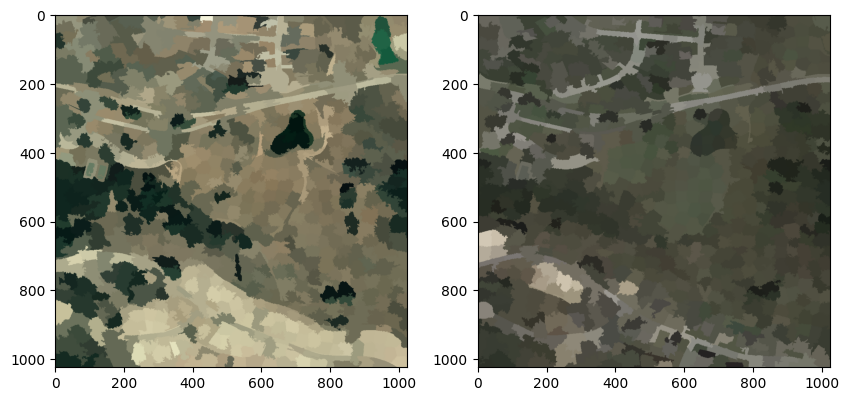

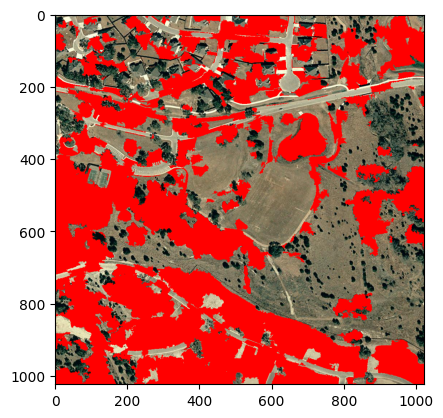

In [ ]:
import numpy as np
from skimage import io, segmentation, color
from skimage.future import graph
import matplotlib.pyplot as plt
from skimage import morphology

# Function to compute mean color of superpixels
def compute_superpixel_means(image, segments):
    out = np.zeros_like(image)
    for segment_value in np.unique(segments):
        mask = segments == segment_value
        mean_color = image[mask].mean(axis=0)
        out[mask] = mean_color
    return out

# Load images
image1 = io.imread('/content/drive/MyDrive/LEVIR-CD/train/A/train_1.png')
image2 = io.imread('/content/drive/MyDrive/LEVIR-CD/train/B/train_1.png')

# Apply SLIC to each image
segments1 = segmentation.slic(image1, n_segments=1000, compactness=10)
segments2 = segmentation.slic(image2, n_segments=1000, compactness=10)

# Visualize superpixels (Optional)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(color.label2rgb(segments1, image1, kind='avg'))
ax[1].imshow(color.label2rgb(segments2, image2, kind='avg'))
plt.show()

# Compute mean colors of superpixels
mean_image1 = compute_superpixel_means(image1, segments1)
mean_image2 = compute_superpixel_means(image2, segments2)

# Compare superpixels to detect changes
threshold = 100  # Adjust this threshold based on your specific needs
change_mask = np.linalg.norm(mean_image1 - mean_image2, axis=-1) > threshold

# Post-processing to remove small objects
cleaned_change_mask = morphology.remove_small_objects(change_mask, min_size=50)

# Visualize changes
change_highlighted = image1.copy()
change_highlighted[cleaned_change_mask] = [255,0,0]  # Highlight changes in red

plt.imshow(change_highlighted)
plt.show()


In [ ]:
import os
import numpy as np
from skimage import io, segmentation, color
from skimage import morphology
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score

# Function to compute mean color of superpixels
def compute_superpixel_means(image, segments):
    out = np.zeros_like(image)
    for segment_value in np.unique(segments):
        mask = segments == segment_value
        mean_color = image[mask].mean(axis=0)
        out[mask] = mean_color
    return out

# Function to preprocess images
def preprocess_images(image_paths):
    preprocessed_images = []
    for image_path in image_paths:
        image = io.imread(image_path)
        segments = segmentation.slic(image, n_segments=1000, compactness=10)
        mean_image = compute_superpixel_means(image, segments)
        preprocessed_images.append(mean_image)
    return np.array(preprocessed_images)

# Paths to your images and labels
num_images = 100  # Set the number of images in your dataset
image_paths_A = ['/content/drive/MyDrive/LEVIR-CD/train/A/train_{}.png'.format(i) for i in range(1, num_images+1)]
image_paths_B = ['/content/drive/MyDrive/LEVIR-CD/train/B/train_{}.png'.format(i) for i in range(1, num_images+1)]
label_paths = ['/content/drive/MyDrive/LEVIR-CD/train/label/train_{}.png'.format(i) for i in range(1, num_images+1)]

# Preprocess images
preprocessed_images_A = preprocess_images(image_paths_A)
preprocessed_images_B = preprocess_images(image_paths_B)

# Load labels
labels = np.array([io.imread(label_path) for label_path in label_paths])

# Ensure labels are binary
labels = (labels > 127).astype(np.uint8)

# Debug: Print shapes of the preprocessed images and labels
print(f'Shape of preprocessed_images_A: {preprocessed_images_A.shape}')
print(f'Shape of preprocessed_images_B: {preprocessed_images_B.shape}')
print(f'Shape of labels: {labels.shape}')

# Split the data into training and validation sets
X_train_A, X_val_A, X_train_B, X_val_B, y_train, y_val = train_test_split(
    preprocessed_images_A, preprocessed_images_B, labels, test_size=0.2, random_state=42)

# Concatenate the two sets of images along the channel dimension
X_train = np.concatenate((X_train_A, X_train_B), axis=-1)
X_val = np.concatenate((X_val_A, X_val_B), axis=-1)

# Debug: Print shapes of the concatenated inputs
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

# Define UNet model
def unet_model(input_size=(256, 256, 6)):
    inputs = tf.keras.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model(input_size=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Flatten the arrays for F1 score calculation
y_val_flat = y_val.flatten()
y_pred_flat = y_pred_thresholded.flatten()

# Calculate F1 score
f1 = f1_score(y_val_flat, y_pred_flat)
print(f'F1 Score: {f1}')


Shape of preprocessed_images_A: (100, 1024, 1024, 3)
Shape of preprocessed_images_B: (100, 1024, 1024, 3)
Shape of labels: (100, 1024, 1024)
Shape of X_train: (80, 1024, 1024, 6)
Shape of X_val: (20, 1024, 1024, 6)
Shape of y_train: (80, 1024, 1024)
Shape of y_val: (20, 1024, 1024)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1024, 1024, 6)]      0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 1024, 1024, 64)       3520      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 1024, 1024, 64)       36928     ['conv2d_38[0][0]']           
       